#### 패키지 로딩하기

In [1]:
from os.path import join
from IPython.display import Image
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV

import os
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = "retina"

#### 데이터 불러오기

In [2]:
data_dir        = os.getenv("HOME") + "/aiffel/kaggle_kakr_housing/data" # 사용할 데이터가 들어있는 폴더 경로
train_data_path = join(data_dir, "train.csv")                            # train 데이터 경로
test_data_path  = join(data_dir, "test.csv")                             # test  데이터 경로

train = pd.read_csv(train_data_path)
test  = pd.read_csv(test_data_path)

In [3]:
train.head() # trian data 살펴보기

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [4]:
test.head() # test data 살펴보기

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


#### 데이터 columns 설명
* ID : 집을 구분하는 번호
* date : 집을 구매한 날짜
* price : **타겟 변수**인 집의 가격
* bedrooms : 침실의 수
* bathrooms : 침실당 화장실 개수
* sqft_living : 주거 공간의 평방 피트
* sqft_lot : 부지의 평방 피트
* floors : 집의 층수
* waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
* view : 집이 얼마나 좋아 보이는지의 정도
* condition : 집의 전반적인 상태
* grade : King County grading 시스템 기준으로 매긴 집의 등급
* sqft_above : 지하실을 제외한 평방 피트
* sqft_basement : 지하실의 평방 피트
* yr_built : 집을 지은 년도
* yr_renovated : 집을 재건축한 년도
* zipcode : 우편번호
* lat : 위도
* long : 경도
* sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
* sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

#### 데이터 전처리

In [5]:
# date 변수 정리, price 떼어내기, id 제거
train["date"] = train["date"].apply(lambda x : (x[:6])).astype(int)
test["date"]  = test["date"].apply(lambda x : (x[:6])).astype(int)

y = train["price"]

del train["id"], train["price"], test["id"]

In [6]:
train.head() # trian data 살펴보기

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [7]:
test.head() # test data 살펴보기

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201412,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,201412,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,201405,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,201504,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,201503,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


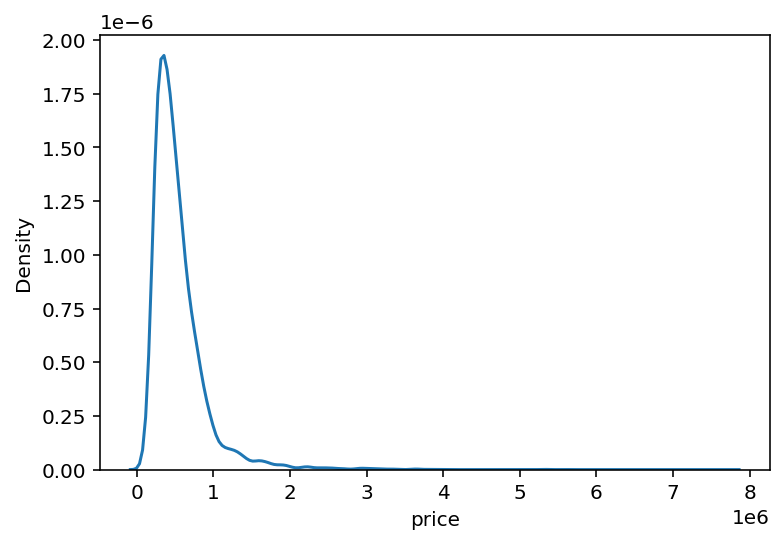

In [8]:
# y의 분포 확인하기
sns.kdeplot(y)
plt.show()

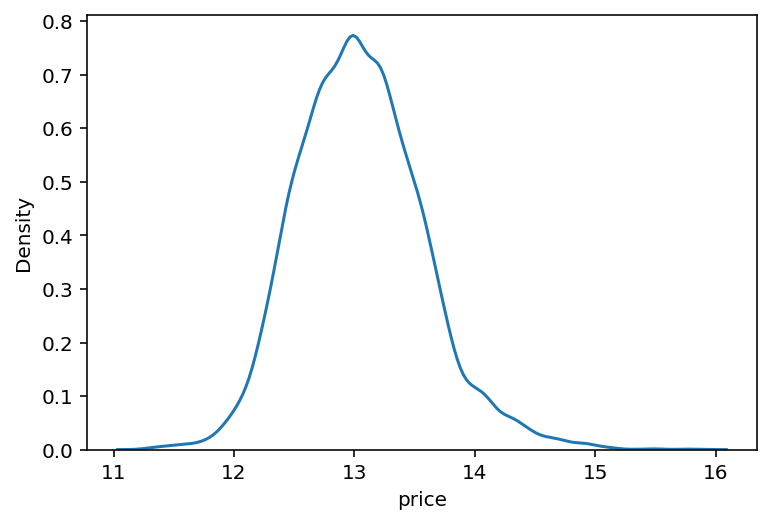

In [9]:
# y의 값이 치우쳐져 있으므로 변환하기
y = np.log1p(y)

sns.kdeplot(y)
plt.show()

In [10]:
# train data 유형 살피기
train.info() # 모두 수치형 데이터이므로 학습에는 문제 없을 듯 함.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

#### model 설계

In [11]:
# 이번 대회에서 평가 척도인 RMSE를 계산하기 위한 함수 만들기
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [12]:
# 모델들 생성
gboost       = GradientBoostingRegressor()
xgboost      = XGBRegressor()
lightgbm     = LGBMRegressor()
randomforest = RandomForestRegressor()

# 모델을 묶어준다
models = [gboost, xgboost, lightgbm, randomforest]

In [13]:
# 모델들을 학습하고 예측한 값을 rmse로 만들어서 DataFrame에 저장하는 함수 만들기
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        # 모델 이름 획득
        model_name = model.__class__.__name__
        
        # train, test 데이터셋 분리
        x_train, x_test, y_train, y_test = train_test_split(train, y, test_size = 0.2)
        
        # 모델 학습
        model.fit(x_train, y_train)
        
        # 예측
        y_pred = model.predict(x_test)
        
        # 예측 결과의 rmse값 저장
        df[model_name] = rmse(y_test, y_pred)
        
        # Data Frame에 저장
        score_df = pd.DataFrame(df, index = ["RMSE"]).T.sort_values("RMSE", ascending = False)
        
    return score_df
    
get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,145134.832491
LGBMRegressor,143303.347145
RandomForestRegressor,132376.193829
XGBRegressor,114643.010832


#### 하이퍼 파라미터 튜닝

In [14]:
# 최적의 하이퍼 파라미터를 찾아주는 함수 만들기
def my_GridSearch(model, train, y, param_grid, verbose = 2, n_jobs = 5):
    # GridSearchCV 모델 초기화
    grid_model = GridSearchCV(model, param_grid = param_grid, scoring = "neg_mean_squared_error", cv = 5, verbose = verbose, n_jobs = n_jobs)
    
    # 모델 학습
    grid_model.fit(train, y)
    
    # 결과값 저장
    params = grid_model.cv_results_["params"]
    score  = grid_model.cv_results_["mean_test_score"]
    
    # 데이터 프레임 생성
    results          = pd.DataFrame(params)
    results["score"] = score
    
    # RMSLE 값 계산 후 정렬
    results["RMSLE"] = np.sqrt(-1 * results["score"])
    results          = results.sort_values("RMSLE")
    
    return results

In [15]:
# 최적의 하이퍼 파라미터를 찾기
param_grid = {
    "max_depth"     : [10, 15],                 # 의사 결정 나무의 깊이, 정수 사용
    "learning_rate" : [0.01, 0.05, 0.1],        # 한 스텝에 이동하는 양을 결정하는 파라미터, 보통 0.0001~0.1 사이의 실수 사용
    "n_estimators"  : [1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000] # 사용하는 개별 모델의 개수, 보통 50~100 이상의 정수 사용
}

model = LGBMRegressor()
my_GridSearch(model, train, y, param_grid, verbose = 2, n_jobs = 5)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   27.8s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:  2.3min
[Parallel(n_jobs=5)]: Done 270 out of 270 | elapsed:  4.2min finished


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,learning_rate,max_depth,n_estimators,score,RMSLE
14,0.01,15,3500,-0.025733,0.160416
15,0.01,15,4000,-0.025736,0.160425
13,0.01,15,3000,-0.025746,0.160456
5,0.01,10,3500,-0.025749,0.160466
4,0.01,10,3000,-0.025752,0.160474
16,0.01,15,4500,-0.025755,0.160484
6,0.01,10,4000,-0.025767,0.160522
17,0.01,15,5000,-0.025771,0.160534
12,0.01,15,2500,-0.025794,0.160604
7,0.01,10,4500,-0.025808,0.160648


In [16]:
# 찾은 하이퍼 파라미터를 가지고 모델을 만들기
model = LGBMRegressor(learning_rate = 0.05, max_depth = 10, n_estimators = 2500)

# 모델을 학습하고 예측값을 csv 파일로 저장하는 함수 만들기
def save_submission(model, train, y, test, model_name, rmsle):
    model.fit(train, y)
    prediction          = model.predict(test)
    prediction          = np.expm1(prediction)
    data_dir            = os.getenv("HOME") + "/aiffel/kaggle_kakr_housing/data"
    submission_path     = join(data_dir, "sample_submission.csv")
    submission          = pd.read_csv(submission_path)
    submission["price"] = prediction
    submission_csv_path = f"{data_dir}/submission_{model_name}_RMSLE_{rmsle}.csv"
    submission.to_csv(submission_csv_path, index = False)
    
save_submission(model, train, y, test, "lgbm", rmsle = "4")

#### 회고록

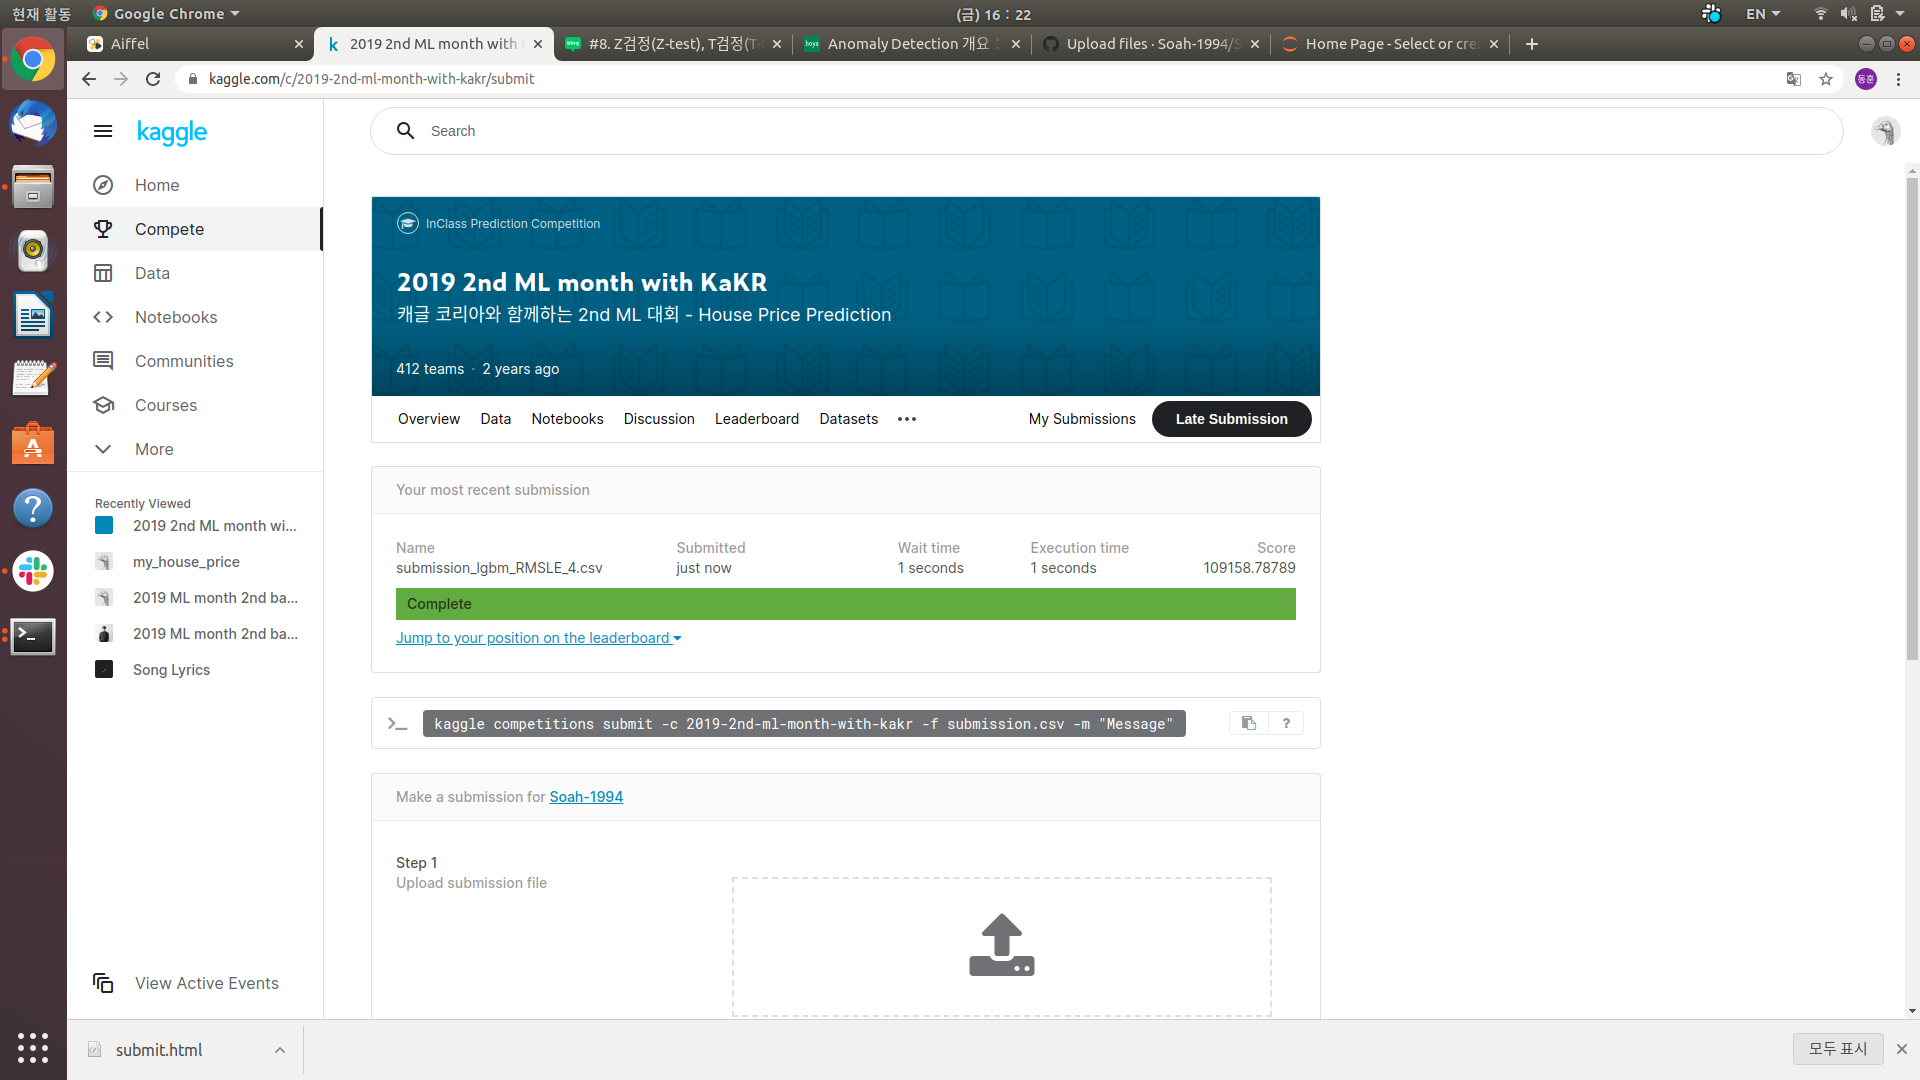

In [4]:
# 캐글 결과값
# Name                             Submitted      Wait time      Execution time      Score
# submission_lgbm_RMSLE_4.csv      just now       1 seconds      1 seconds           109158.78789
img_dir = os.getenv("HOME") + "/aiffel/kaggle_kakr_housing/data/image.png"
Image(img_dir)

In [ ]:
# 데이터를 불러오고 두 개의 데이터를 각각 어떻게 전처리 할지를 이해하는데 좀 시간이 걸렸음. (로그 변환을 어떤 변수를 시켜야 하는지? 같은)
# 어떤 모델을 후보에 올려서 비교할 것인지, 이 데이터에는 어떤 모델이 좋을지 판단하는 것이 어려웠음. (결론은 노드에서 쓴 것들을 종합해봄)
# 각각 모델에 어떤 하이퍼 파라미터가 좋을지 몰라서 GridSearchCV에 여러 개의 하이퍼 파라미터를 돌림.
# 그랬더니 어떤 파라미터는 최적의 하이퍼 파라미터를 찾는데 1시간 30분 ~ 2시간 가량 걸려서 깜작 놀람.
# 다 돌려보니 LGBMRegressor가 가장 빨리 하이퍼 파라미터를 찾는 것을 깨달음. (모델들의 성능은 85% 이상의 R^2를 보이므로 모델은 고려 안해도 될거같음)
# 그래서 같은 알고리즘으로 많은 하이퍼 파라미터를 넣어보니 lr = 0.05, max_depth = 10이고 n_estimators는 100이상일때 커질수록 좋은 결과가 나왔음.
# 그래서 1000 ~ 5000 사이의 n_estimators를 넣어서 최적의 하이퍼 파라미터를 찾으니 3500이 나옴.
# 하지만 결과는 n_estimators가 3500일 때는 루브릭 평가 중 하나인 Private score 기준 110000이하로 내려가지 않음.
# 그래서 500단위로 돌려서 평가해보니 2500일때 위의 결과값이 나옴.

# 말로만 들어보고 도전해보지 못한 캐글을 해봤는데, 지금까지 캐글은 실력자들만 하는 것인줄 알았다. 그치만 이번 노드를 통해 배우기 위해 할수도
# 있다는것을 깨달았다.